# Data Cleaning and Exploratory Data Analysis (EDA)

## Dataset Overview
- Link: https://www.kaggle.com/datasets/chaditya95/epileptic-seizures-dataset
- Collected in a clinical setting​
- Participants: 500​
- Signal: 1-channel EEG signal​
- Duration: 23.5 seconds per participant​, 178 data points/second
- Label distrubution: 80% Non-seizure (9200), 20% Seizure (2300)

In [77]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

## I. Data Cleaning
- Input: original dataset: data/data.csv
- Output: 

In [78]:
df = pd.read_csv("data/data.csv")

### 1) Parse Row ID

In [79]:
df.iloc[:, 0]

0        X21.V1.791
1        X15.V1.924
2           X8.V1.1
3         X16.V1.60
4         X20.V1.54
            ...    
11495    X22.V1.114
11496    X19.V1.354
11497      X8.V1.28
11498    X10.V1.932
11499    X16.V1.210
Name: Unnamed: 0, Length: 11500, dtype: object

Here we can see that:
- X: Participant number
- V: Version of the data
- the part after the second dot: Index of the 23 seconds (23 seconds per participant)

Let's split it into separate columns.

In [80]:
# Split the first column into three new columns
df[['second_no', 'version', 'pid']] = df.iloc[:, 0].str.split('.', expand=True)

# Extract the numeric parts and replace X and V directly
df['second_no'] = df['second_no'].str.extract('(\d+)').astype(int)  # Replace X with its numeric part
df['version'] = df['version'].str.extract('(\d+)').astype(int)  # Replace V with its numeric part
df['pid'] = df['pid'].fillna(0).astype(int) # Convert the 'pid' column to integer for sorting and fill None values in 'num' with a default value (e.g., 0)

# Some formatting
# Rename the 'Unnamed: 0' column to 'id'
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
# Reorder the columns to move num, X, V between id and X1
df = df[['id', 'pid', 'second_no', 'version', 'X1'] + [col for col in df.columns if col not in ['id', 'pid', 'second_no', 'version', 'X1']]]
# Sort the DataFrame 
df_sorted = df.sort_values(by=['version', 'pid', 'second_no'])

df_sorted.head(5)

,id,pid,second_no,version,X1,X2,X3,X4,X5,X6,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
9065,X1.V1,0,1,1,12,22,35,45,69,74,...,-18,-32,-47,-53,-48,-40,-17,-23,-32,5
9699,X2.V1,0,2,1,-41,-50,-53,-49,-35,-28,...,34,22,4,-18,-31,-27,-26,-21,-30,5
2988,X3.V1,0,3,1,-45,-60,-73,-70,-70,-51,...,1,-21,-38,-44,-31,-17,4,35,59,5
3227,X4.V1,0,4,1,68,63,52,45,46,45,...,-22,-47,-68,-85,-92,-96,-83,-73,-66,5
8967,X5.V1,0,5,1,-59,-48,-35,-22,4,18,...,4,-5,-16,-29,-35,-21,3,35,66,5


Now:
- pid: Participant number
- second_no: Index of the 23 seconds
- version: Version of the data
- 178 columns stands for the 178 samples within one second

### 2) Unify version

Except for Version 1, We found 4 different versions (11,12,13,14), each of the version has 23 rows of data. 

In [81]:
df[df['version'] != 1].sort_values(by=['version', 'pid', 'second_no']).head(50)

,id,pid,second_no,version,X1,X2,X3,X4,X5,X6,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
3841,X1.V11,0,1,11,-24,-22,-17,-18,-19,-14,...,33,46,36,31,33,37,45,33,20,4
7371,X2.V11,0,2,11,-1,-19,-30,-29,-33,-29,...,-59,-41,-19,18,37,40,32,27,10,4
11434,X3.V11,0,3,11,-11,-35,-64,-81,-90,-71,...,26,31,39,46,46,48,48,54,46,4
5149,X4.V11,0,4,11,54,43,38,18,-8,-27,...,-31,-17,-27,-28,-44,-27,2,19,26,4
7813,X5.V11,0,5,11,17,6,-10,-21,-31,-44,...,-97,-81,-64,-32,4,20,18,17,19,4
9833,X6.V11,0,6,11,17,25,36,48,48,38,...,74,69,85,88,84,68,57,52,57,4
6859,X7.V11,0,7,11,64,82,93,89,78,69,...,12,10,7,-6,-40,-74,-89,-103,-107,4
6872,X8.V11,0,8,11,-102,-96,-81,-57,-23,-8,...,-18,-1,-3,-18,-43,-59,-64,-65,-67,4
2238,X9.V11,0,9,11,-50,-43,-37,-46,-75,-84,...,100,91,65,14,-13,-36,-40,-19,17,4
3920,X10.V11,0,10,11,51,79,94,97,108,114,...,-68,-56,-31,-5,-5,-3,3,16,12,4


Therefore, we assign a unique participant id to each of these versions, and unify the version to 1.

In [82]:
# Find the maximum existing pid
max_pid = df['pid'].max()
# Identify unique versions that are not 1
versions_with_empty_pid = df[df['version'] != 1]['version'].unique()
# Assign a unique pid to each participant and unify the version to 1
for i, version in enumerate(versions_with_empty_pid):
    new_pid = max_pid + i + 1  # Start from max_pid + 1
    df.loc[(df['version'] == version), 'pid'] = new_pid
    df.loc[(df['version'] == version), 'version'] = 1

print (f"After data cleaning:")
print (f"There are {len(df['pid'].unique())} patients.")
print (f"There are {len(df['second_no'].unique())} seconds per participant.")
print (f"There are {len(df['version'].unique())} versions.") 

After data cleaning:
There are 500 patients.
There are 23 seconds per participant.
There are 1 versions.


### 3) label
The original data has 5 labels:

- 5 - eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open
- 4 - eyes closed, means when they were recording the EEG signal the patient had their eyes closed
- 3 - Yes they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area
- 2 - They recorder the EEG from the area where the tumor was located
- 1 - Recording of seizure activity

Although there are 5 classes, most authors have done binary classification, namely class 1 (Epileptic seizure) against the rest. So we convert 2-5 to 0: Non-seizure, and 1: Seizure

In [83]:
# Binary classification: 1: Seizure, 0: Non-seizure
df['y'] = df['y'].apply(lambda x: 0 if x != 1 else x)

Now, we have completed data cleaning.

In [84]:
df.head(5)

,id,pid,second_no,version,X1,X2,X3,X4,X5,X6,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,791,21,1,135,190,229,223,192,125,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,X15.V1.924,924,15,1,386,382,356,331,320,315,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,1,8,1,-32,-39,-47,-37,-32,-36,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,X16.V1.60,60,16,1,-105,-101,-96,-92,-89,-95,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,X20.V1.54,54,20,1,-9,-65,-98,-102,-78,-48,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


In [ ]:
# Save the cleaned data
df.to_csv("data/data_cleaned.csv")

## II. EDA

### 1. Data imbalance

80% Non-seizure(0); 20% Seziure(1)

In [86]:
df['y'].value_counts()

0    9200
1    2300
Name: y, dtype: int64

### 2. Consistency of label within one participant data
For a single participant, all 23 seconds of data has the same label.

In [87]:
# Group by 'pid' and check unique values of 'y'
y_consistency = df.groupby('pid')['y'].nunique()

# Identify pids where y does not stay the same
inconsistent_pids = y_consistency[y_consistency > 1].index

# Display inconsistent pids and their unique y values
for pid in inconsistent_pids:
    unique_y_values = df[df['pid'] == pid]['y'].unique()
    print(f"PID: {pid} has inconsistent y values: {unique_y_values}")

### 3. The range of EEG signal values
Seizure data exhibits more variability and distinct feature activations.

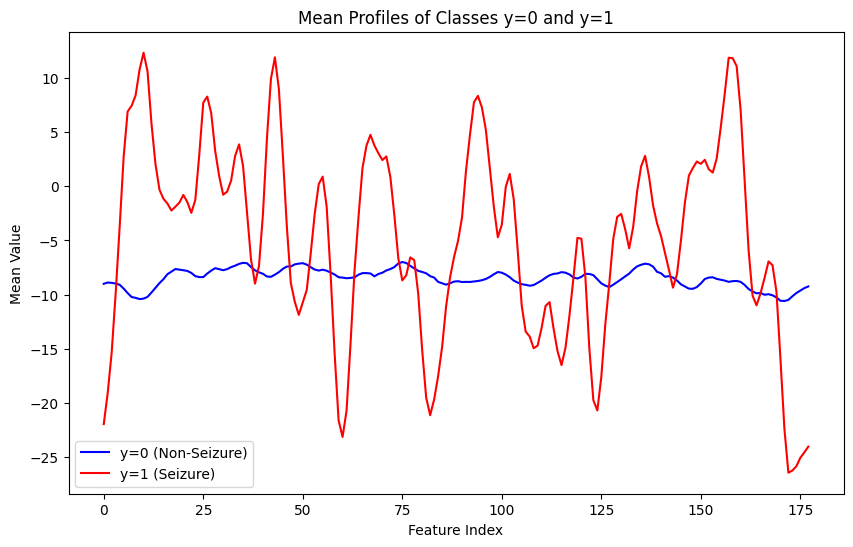

In [97]:
# 1: Plot Mean Profiles

# Separate X based on y values
X_class_0 = df[y == 0].loc[:, 'X1':'X178'].values
X_class_1 = df[y == 1].loc[:, 'X1':'X178'].values

# Compute the mean profile for each class
mean_class_0 = np.mean(X_class_0, axis=0)
mean_class_1 = np.mean(X_class_1, axis=0)

# Plot the mean profiles
plt.figure(figsize=(10, 6))
plt.plot(mean_class_0, label='y=0 (Non-Seizure)', color='blue')
plt.plot(mean_class_1, label='y=1 (Seizure)', color='red')
plt.title('Mean Profiles of Classes y=0 and y=1')
plt.xlabel('Feature Index')
plt.ylabel('Mean Value')
plt.legend()
plt.show()


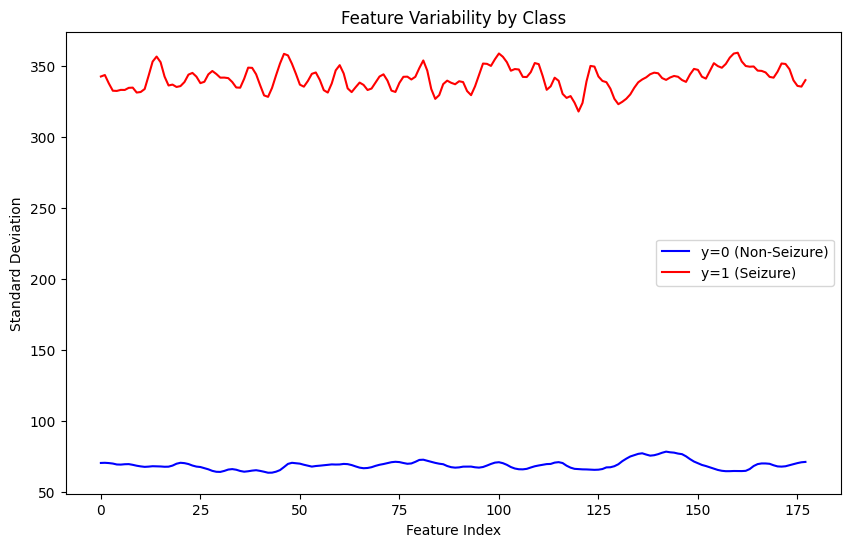

In [89]:
# 2: Standard Deviation/Variance of Features

# Compute standard deviation for each class
std_class_0 = np.std(X_class_0, axis=0)
std_class_1 = np.std(X_class_1, axis=0)

# Plot the standard deviations
plt.figure(figsize=(10, 6))
plt.plot(std_class_0, label='y=0 (Non-Seizure)', color='blue')
plt.plot(std_class_1, label='y=1 (Seizure)', color='red')
plt.title('Feature Variability by Class')
plt.xlabel('Feature Index')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()


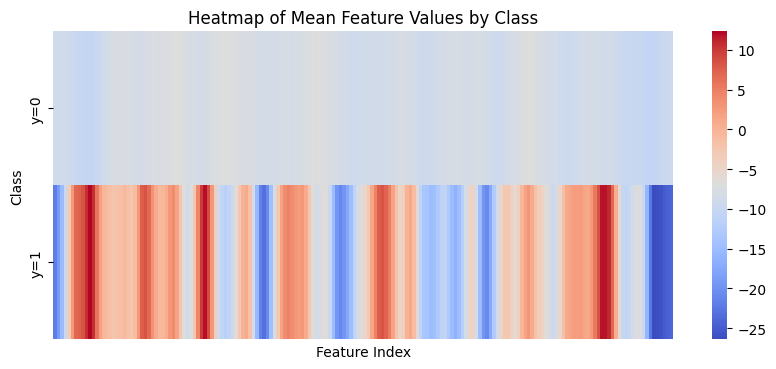

In [90]:
# 3: Heatmaps for Aggregated Views

# Compute mean feature values for each class
mean_class_0 = np.mean(X_class_0, axis=0).reshape(1, -1)
mean_class_1 = np.mean(X_class_1, axis=0).reshape(1, -1)

# Combine into one array for visualization
combined_means = np.vstack([mean_class_0, mean_class_1])

# Plot heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(combined_means, annot=False, cmap='coolwarm', xticklabels=False, yticklabels=['y=0', 'y=1'])
plt.title('Heatmap of Mean Feature Values by Class')
plt.xlabel('Feature Index')
plt.ylabel('Class')
plt.show()


Darker red (or warm colors): Indicates higher mean values for that feature.
Darker blue (or cool colors): Indicates lower mean values for that feature.

### 4. Differences between participants

- The decision boundary between seizure and non-seizure data is pretty clear.
- Non-seizure data is more clustered, while seizure data is more diverse and scattered into the whole space.

#### T-SNE

/Users/mikky/miniconda3/envs/epileptic/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


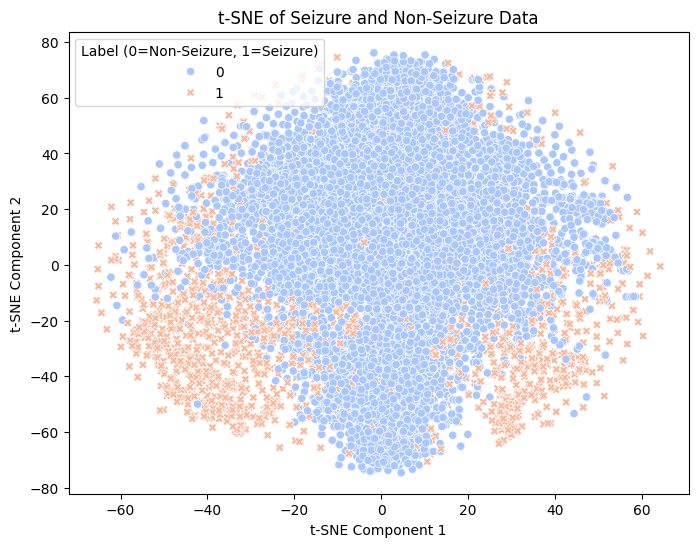

In [91]:
# 2D

# Get data
X = df.loc[:, 'X1':'X178'].values  # All feature columns
y = df['y'].values  # Labels (non-seizure/seizure)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X)

# Visualize the t-SNE features
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='coolwarm', style=y)
plt.title('t-SNE of Seizure and Non-Seizure Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Label (0=Non-Seizure, 1=Seizure)')
plt.show()


/Users/mikky/miniconda3/envs/epileptic/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


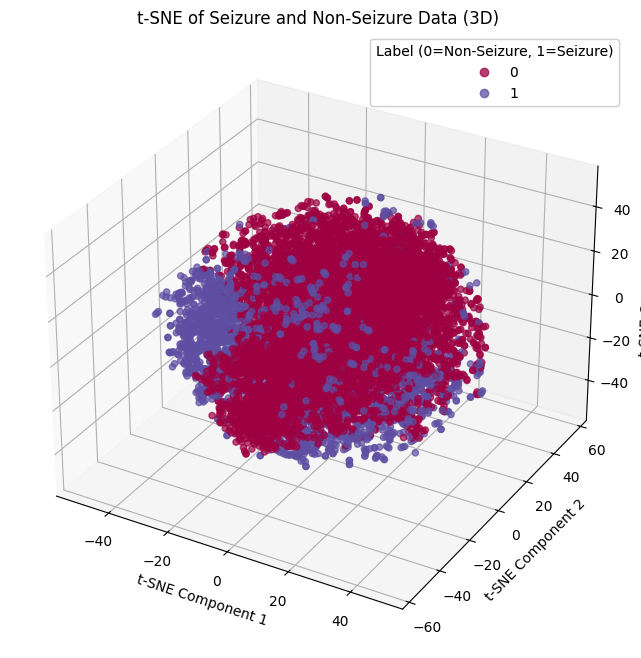

In [92]:
# 3D

# t-SNE with 3 components
tsne = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=1000)
X_tsne_3d = tsne.fit_transform(X)

# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2],
    c=y, cmap='Spectral', marker='o', alpha=0.7
)
legend = ax.legend(
    *scatter.legend_elements(),
    title="Label (0=Non-Seizure, 1=Seizure)"
)
ax.add_artist(legend)
ax.set_title('t-SNE of Seizure and Non-Seizure Data (3D)')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
plt.show()